# Imports

In [1]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, shuffle

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, auc
from sklearn.ensemble import RandomForestRegressor

import dill
# import datetime

import itertools

In [2]:
%matplotlib inline

In [ ]:
# dill.dump_session('cache/RandomForest.db')

In [ ]:
# dill.load_session('cache/RandomForest.db')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# data_path = 'drive/My Drive/Colab Notebooks/NIR/data/'

In [4]:
data_path = 'data/prepared/'

In [4]:
results_path = 'vector/results_LD_SD/FT_sum_model/'

# Data reading

## Reading

### Synth data for model building

In [5]:
X_train = pd.read_csv(data_path + 'X_train.csv')
X_test = pd.read_csv(data_path + 'X_test.csv')

Y_train = pd.read_csv(data_path + 'y_train.csv')
Y_test = pd.read_csv(data_path + 'y_test.csv')

### Real data for analysis

In [6]:
conditions = ['LD', 'SD']

In [7]:
X_real = {}
Y_real = {}
for cond in conditions:
    X_real[cond] = pd.read_csv(data_path + 'real_X_' + cond + '.csv')
    Y_real[cond] = pd.read_csv(data_path + 'real_Y_' + cond + '.csv')

In [9]:
Y_real['LD']['days'] = X_real['LD'].days.tolist()[1:] + [40]
Y_real['SD']['days'] = X_real['SD'].days.tolist()[1:] + [34]

In [10]:
days = list(set(X_test.days.values))
days.append(40)
days.sort()
days

[9, 11, 13, 15, 17, 19, 20, 22, 25, 28, 30, 31, 32, 34, 37, 40]

## Add FTs' sum to data

In [16]:
targets = Y_train.drop('days', axis=1).columns.tolist()
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [18]:
FTs = [name for name in X_train.drop('days', axis=1).columns if name not in targets]
FTs

['FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc']

### Train & test changing

In [42]:
X_train['FTs'] = X_train[FTs].sum(axis=1)
X_test['FTs'] = X_test[FTs].sum(axis=1)

X_train = X_train.drop(FTs, axis=1)
X_test = X_test.drop(FTs, axis=1)

In [43]:
X_train.head(2)

,AP1,FD,LFY,TFL1a,TFL1c,days,FTs
0,22.645901,25.899794,12.032502,22.923125,22.942060,9,60.071674
1,6.644086,31.055430,3.375855,24.549205,26.729047,9,32.227273


In [44]:
X = X_train.drop('days', axis=1)
Y = Y_train.drop('days', axis=1)

### Real data changing

In [45]:
for cond in conditions:
    X_real[cond]['FTs'] = X_real[cond][FTs].sum(axis=1)
    X_real[cond] = X_real[cond].drop(FTs, axis=1)

# Random forest

## Model building

In [46]:
def GridS(model, grid, cv, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
#                       scoring = MSE5,
#                       refit = MSE5,
                      cv=cv, 
                      verbose=10)

### Rough tuning

In [47]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [20, 50, 100, 300],
    'min_samples_leaf': [10, 20, 50, 100],
    'max_depth': [5, 8, 20, None]
}

In [48]:
gs = GridS(model, grid, cv)

In [49]:
gs.fit(X.values, Y.values)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  6

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [20, 50, 100, 300], 'min_samples_leaf': [10, 20, 50, 100], 'max_depth': [5, 8, 20, None]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [50]:
gs.best_params_

{'max_depth': 20, 'min_samples_leaf': 10, 'n_estimators': 300}

### Fine tuning (?)

In [ ]:
model = RandomForestRegressor()

cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [250, 300, 350],
    'min_samples_leaf': [5, 10, 15],
    'max_depth': [15, 20, 25, None]
}

In [ ]:
gs = GridS(model, grid, cv)

In [ ]:
gs.fit(X.values, Y.values)

In [ ]:
gs.best_params_

Get the model with best score on the cross-validation:

In [51]:
best_model = gs.best_estimator_

### Save the model

In [52]:
with open('cache/Random_forest_FT_sum.md', 'wb') as ouf:
    dill.dump(best_model, ouf)

## Make predictions

In [53]:
predictions_train = best_model.predict(X.values)
predictions_test = best_model.predict(X_test.drop('days', axis=1).values)

## Evaluating

In [54]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions, multioutput='raw_values').round(2)
    R2 = r2_score(true_values.values, predictions, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs,'R2': R2, 'r': r}, index=targets, )
    return df

In [5]:
def comparsion_plot(true_values, predictions, data_type = 'train', current_target=targets[0], s=3, format='svg'):
    plt.scatter(true_values, predictions, s=s)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Predictions on ' + data_type)
    
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    plt.savefig(results_path + current_target + '_' + data_type + f'.{format}', bbox_inches='tight', format=format, dpi=300)
    plt.show()

Scores on train:  
(r - Pearson correlation)

In [56]:
print_scores(Y, predictions_train)

,MSE,R2,r
AP1,12621.77,0.87,0.93
FD,143.57,0.79,0.89
LFY,2020.15,0.65,0.81
TFL1a,30.85,0.83,0.91
TFL1c,46.20,0.78,0.89


Scores on test:

In [57]:
print_scores(Y_test.drop('days', axis=1), predictions_test)

,MSE,R2,r
AP1,18978.83,0.80,0.90
FD,161.51,0.76,0.87
LFY,2820.52,0.52,0.72
TFL1a,36.15,0.80,0.90
TFL1c,51.82,0.75,0.87


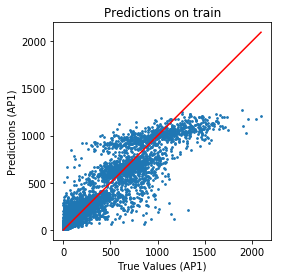

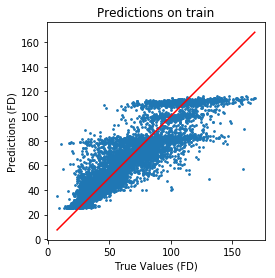

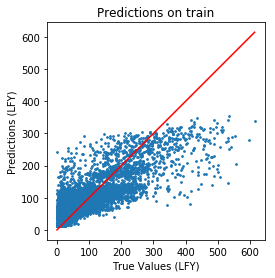

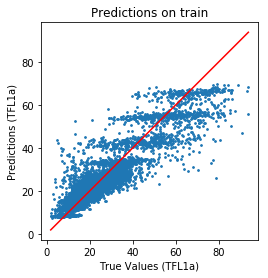

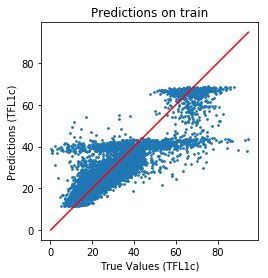

In [6]:
for i in range(5):
    comparsion_plot(Y.iloc[:, i], predictions_train[:, i], data_type='train', current_target=targets[i])

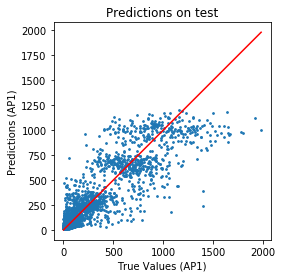

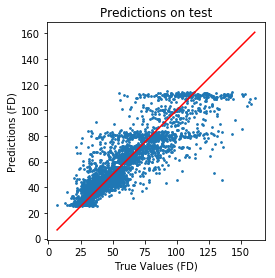

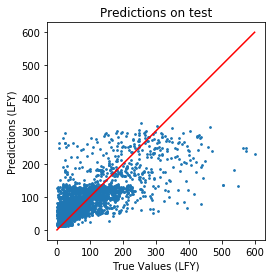

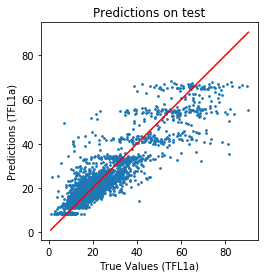

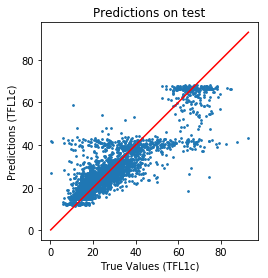

In [7]:
for i in range(5):
    comparsion_plot(Y_test.drop('days', axis=1).iloc[:, i], predictions_test[:, i], data_type='test', current_target=targets[i])

# Real data

In [8]:
def time_long_plot(true_values, predicted, condition = 'LD', predict_method = 'static', format='svg'):
    for i in range(5):
        plt.plot(true_values['days'], true_values.iloc[:,i].values, 'o')
        plt.plot(true_values['days'], predicted.iloc[:, i].values, '-')
        plt.title(targets[i] + ' ' + condition + f' ({predict_method} prediction method)')
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions'])
        
        fig_path = results_path + predict_method + '/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_pred_on_real.{format}', 
                    bbox_inches='tight', format=format, dpi=300)
        plt.show()

In [61]:
def predict(data):
    
    predictions = pd.DataFrame(best_model.predict(data.values), columns = targets)
     
    return predictions

## Static

In [9]:
predictions_real = {}
predictions_real['LD'] = best_model.predict(X_real['LD'].drop('days', axis=1).values)
predictions_real['SD'] = best_model.predict(X_real['SD'].drop('days', axis=1).values)

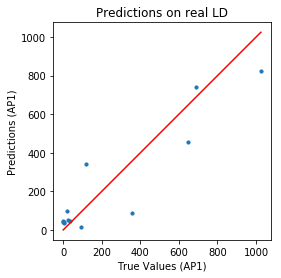

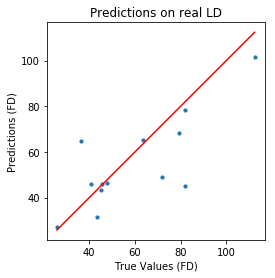

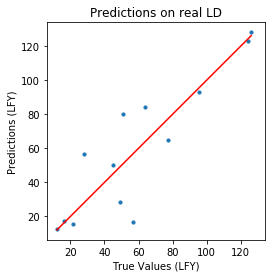

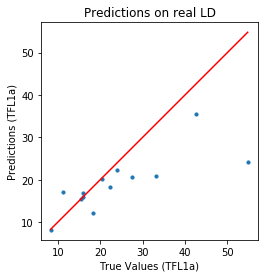

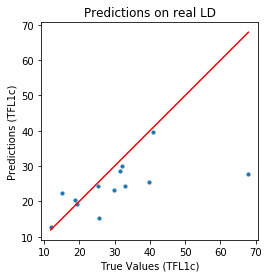

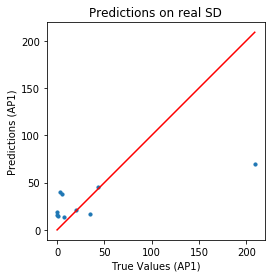

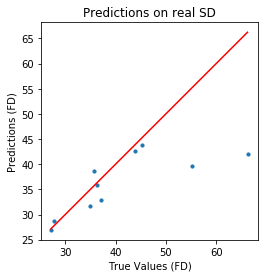

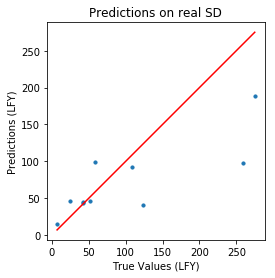

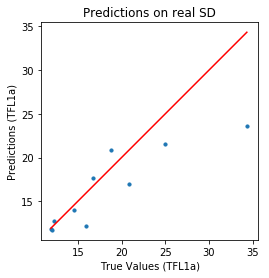

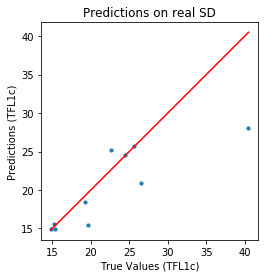

In [10]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond][:, i], data_type='real ' + cond, current_target=targets[i], s=10)

In [64]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
            MSE    R2     r
AP1    16969.55  0.84  0.92
FD       239.05  0.57  0.78
LFY      334.97  0.75  0.88
TFL1a     97.78  0.38  0.77
TFL1c    162.63  0.15  0.59
SD
           MSE    R2     r
AP1    2308.19  0.37  0.79
FD       87.07  0.35  0.76
LFY    4295.14  0.48  0.81
TFL1a    16.15  0.64  0.89
TFL1c    21.25  0.60  0.84


In [13]:
print_scores(Y_real['LD'].drop('days', axis=1), predictions_real['LD'])

,MSE,R2,r
AP1,16969.55,0.84,0.92
FD,239.05,0.57,0.78
LFY,334.97,0.75,0.88
TFL1a,97.78,0.38,0.77
TFL1c,162.63,0.15,0.59


In [12]:
for cond in conditions:
    predictions_real[cond] = pd.DataFrame(predictions_real[cond], columns=targets)

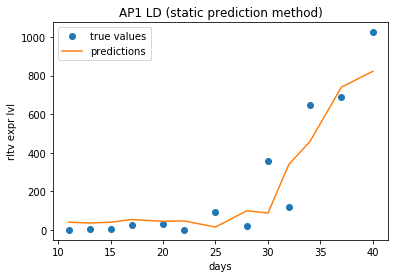

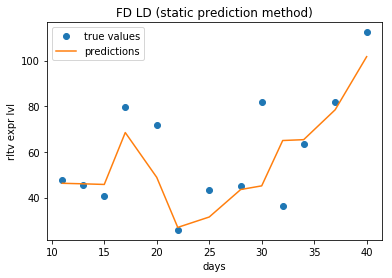

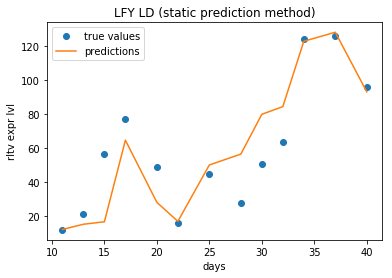

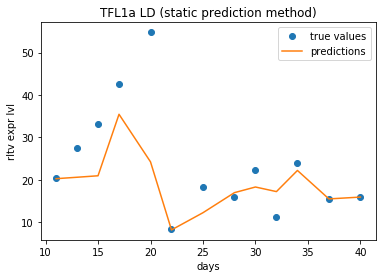

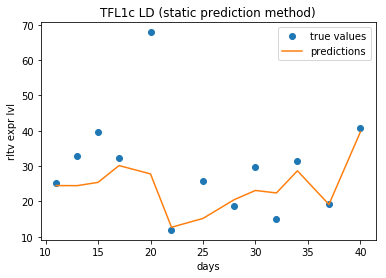

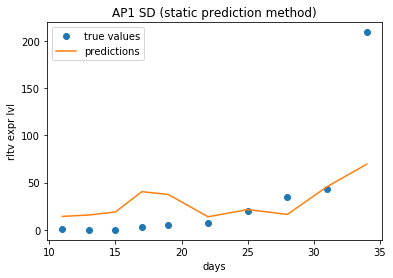

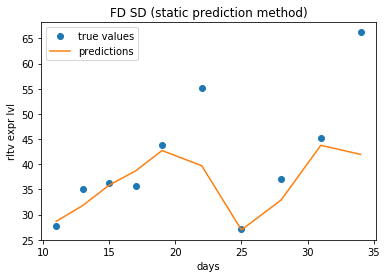

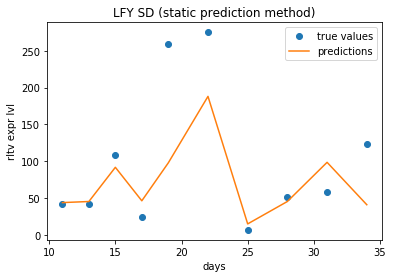

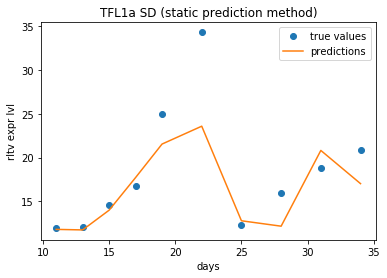

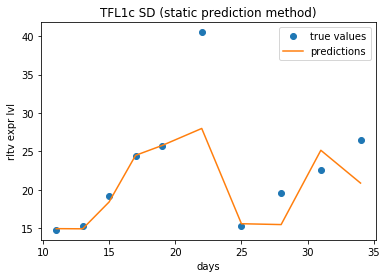

In [14]:
for cond in conditions:
    time_long_plot(Y_real[cond], predictions_real[cond], cond)

## Dynamic

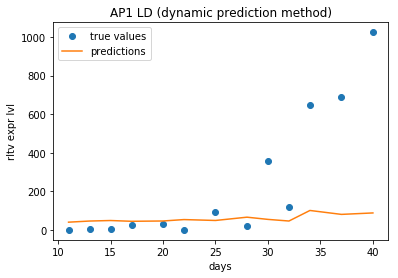

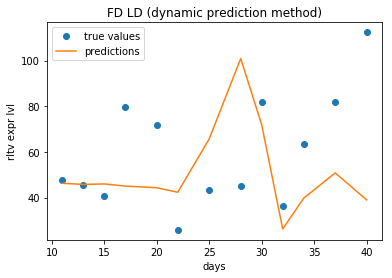

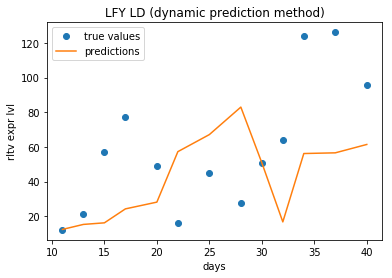

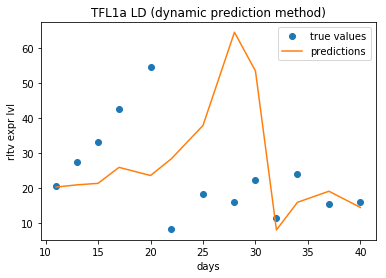

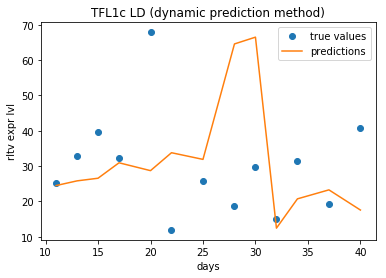

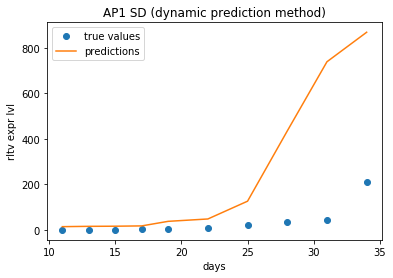

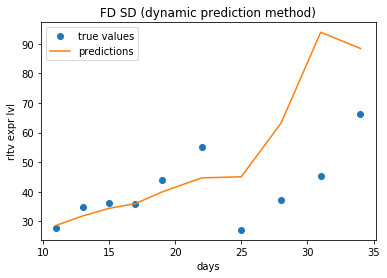

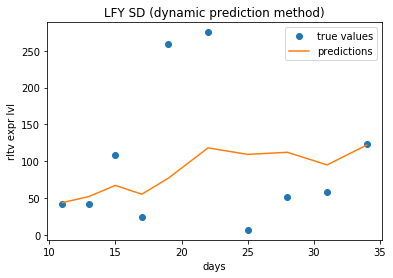

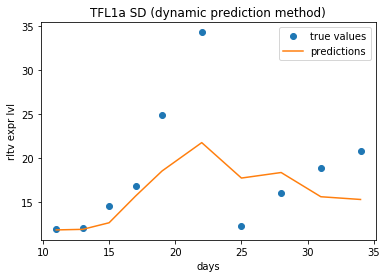

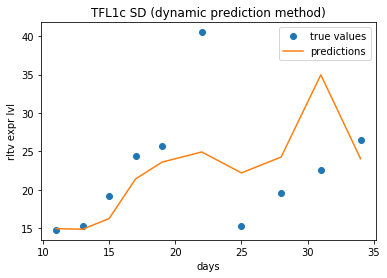

In [15]:
for cond in conditions:

    X_temp = X_real[cond].drop('days', axis = 1)

    predictions_real[cond] = pd.DataFrame(columns=targets)

    for i in X_real[cond].index:
        current_predictions = predict(X_temp.loc[[i]])
        predictions_real[cond] = predictions_real[cond].append(current_predictions, ignore_index = True)
        X_temp[targets] = current_predictions.values[0]

    time_long_plot(Y_real[cond], predictions_real[cond], cond, 'dynamic')

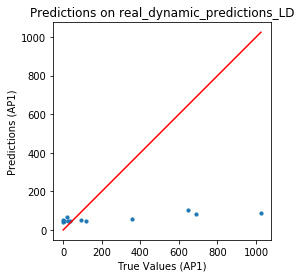

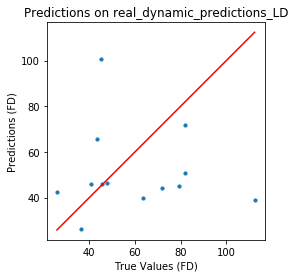

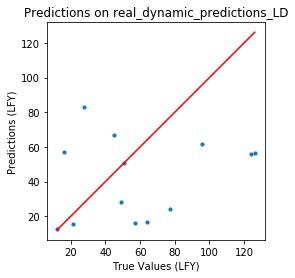

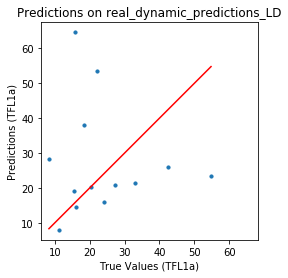

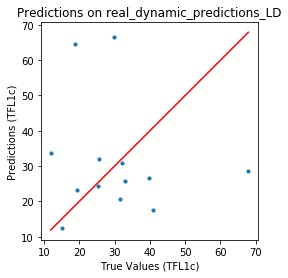

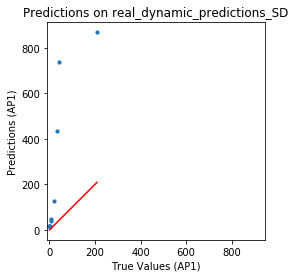

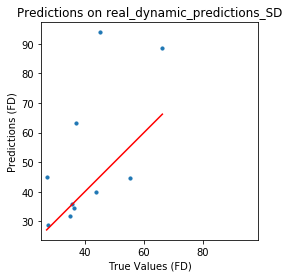

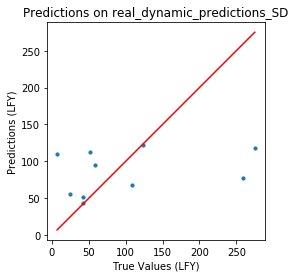

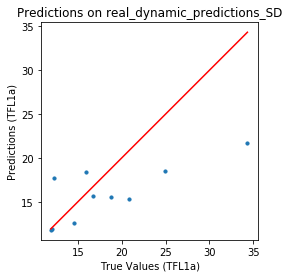

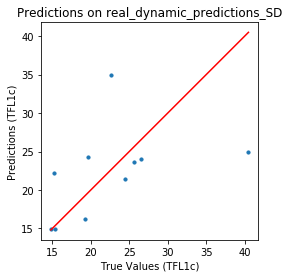

In [16]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond].iloc[:, i], data_type='real_dynamic_predictions_' + cond, current_target=targets[i], s=10)

In [69]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions.values, multioutput='raw_values').round(2)
    R2 = r2_score(true_values.values, predictions.values, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.values.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs,'R2': R2, 'r': r}, index=targets, )
    return df

In [70]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
             MSE    R2     r
AP1    127611.73 -0.19  0.86
FD        995.87 -0.80 -0.05
LFY      1769.14 -0.33  0.22
TFL1a     436.55 -1.78 -0.08
TFL1c     493.32 -1.57 -0.13
SD
             MSE     R2     r
AP1    109325.56 -28.70  0.83
FD        400.37  -2.00  0.63
LFY      7615.44   0.07  0.31
TFL1a      28.13   0.37  0.76
TFL1c      49.42   0.08  0.44


In [17]:
print_scores(Y_real['LD'].drop('days', axis=1), predictions_real['LD'])

,MSE,R2,r
AP1,127611.73,-0.19,0.86
FD,995.87,-0.80,-0.05
LFY,1769.14,-0.33,0.22
TFL1a,436.55,-1.78,-0.08
TFL1c,493.32,-1.57,-0.13


In [18]:
print_scores(Y_real['SD'].drop('days', axis=1), predictions_real['SD'])

,MSE,R2,r
AP1,109325.56,-28.70,0.83
FD,400.37,-2.00,0.63
LFY,7615.44,0.07,0.31
TFL1a,28.13,0.37,0.76
TFL1c,49.42,0.08,0.44


# Knock out simulation

## Methods definitions

In [ ]:
# def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic'):
#     x_axis = true_values['days']
    
#     for i in range(5):        
#         plt.plot(x_axis, true_values.iloc[:,i].values, 'o')
#         plt.plot(x_axis, predicted.iloc[:, i], '--')
#         plt.plot(x_axis, pred_for_ko.iloc[:, i], '-')
        
#         if type(KO_gene) == type(''):
#             KO_name = KO_gene
#         else:            
#             KO_name = '_'.join(KO_gene)

#         plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
#         plt.xlabel('days')
#         plt.ylabel('rltv expr lvl')
#         plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
#         plt.savefig(results_path + f'{predict_method}/KOs/{targets[i]}/{targets[i]}_{condition}_with_{KO_gene}_KO.png', 
#                     bbox_inches='tight', dpi=300)
#         plt.show()

In [ ]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition, predict_method = 'dynamic'):
    x_axis = true_values['days']
    
    for i in range(5):        
        plt.plot(x_axis, true_values.iloc[:,i].values, 'o')
        plt.plot(x_axis, predicted.iloc[:, i], '--')
        plt.plot(x_axis, pred_for_ko[:, i], '-')
        
        if type(KO_gene) == type(''):
            KO_name = KO_gene
        else:            
            KO_name = '_'.join(KO_gene)

        plt.title(targets[i] + f' ({condition} with {KO_gene} KO)') # for correct title
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
        
        fig_path = results_path + f'{predict_method}/KOs/{targets[i]}/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{targets[i]}_{condition}_with_{KO_gene}_KO.png', 
                    bbox_inches='tight', dpi=300)
        plt.show()

## KO Iterations set

In [ ]:
targets_with_cond = [name + '_LD' for name in targets]
targets_with_cond = targets_with_cond + [name + '_SD' for name in targets]

In [ ]:
targets_with_cond

In [ ]:
genes = X_real['LD'].drop('days', axis=1).columns.tolist()

In [ ]:
genes

In [ ]:
targets

In [ ]:
FTs = [name for name in genes if name.startswith('FT')]
FTs

In [ ]:
def FTs_combos(massive = FTs, number = 2):
    
    FTset = []
    comb = list(itertools.combinations(massive, number))
    
    for c in comb:
        FTset.append(list(c))

    return FTset

In [ ]:
FT_pairs = FTs_combos(FTs, 2)
FT_pairs

In [ ]:
FT_trios = FTs_combos(FTs, 3)
FT_trios

In [ ]:
FT_quads = FTs_combos(FTs, 4)
FT_quads

In [ ]:
KO_iterations = [targets, FTs, FT_pairs, FT_trios, FT_quads]

## KO simulations

In [ ]:
AUC = pd.DataFrame(0, index=targets_with_cond, columns=['WT'])

In [ ]:
for ko_genes in KO_iterations:
    for cond in conditions:
        for ko_name in ko_genes:

            X_ko = X_real[cond].copy()
            X_ko = X_ko.drop('days', axis = 1)

            pred_ko = [0 for i in range(len(X_ko))]
            
            column = ko_name
            
            if type(ko_name) != type(''):
                ko_name = list(ko_name)
                column = '_'.join(ko_name)
            
            # predictions with KOs:
            for i in range(len(X_ko)):
                X_ko[ko_name] = 0
                pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
                X_ko[targets] = pred_ko[i][0]

            pred_ko = np.array(pred_ko).squeeze()
            
            # plots:
            time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
            
            # AUCs table:
            days_axis = Y_real[cond]['days']
            for i in range(5):
                current_target = targets[i] + '_' + cond
                AUC.loc[current_target, 'WT'] = auc(days_axis, predictions_real[cond].iloc[:, i])
                AUC.loc[current_target, column] = auc(days_axis, pred_ko[:, i])

In [ ]:
X_ko

In [ ]:
AUC.T

# FT dynamics

In [ ]:
FTs

In [ ]:
X_real['LD']

In [ ]:
for f in FTs:
    plt.plot(X_real['LD'].days, X_real['LD'][f], '-o')
    plt.legend(FTs)

In [ ]:
plt.plot(X_real['LD'].days, X_real['LD']['A'], '-o')
plt.plot(X_real['LD'].days, X_real['LD']['FTa2'], '-o')
plt.legend(['LFY', 'FTa2'])

# AUCs

In [ ]:
# AUC = pd.read_csv('results/AUCs.csv', index_col = 0, sep=';')

In [ ]:
AUC.T

In [ ]:
AUC_norm = AUC.T / AUC.WT

In [ ]:
AUC_norm

## Heatmap

In [ ]:
def my_heatmap(data, figsize = (15, 5)):
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(data, robust = True)
    plt.xlabel('KO genes')
    plt.ylabel('AUC relative to WT AUC')
    
    fig_path = results_path + 'dynamic/'

    if not os.path.exists(fig_path):
        os.makedirs(fig_path)

    plt.savefig(fig_path + 'Heatmap.png', bbox_inches='tight', dpi=300)

In [ ]:
my_heatmap(AUC_norm.T)

## Barplots

In [ ]:
def AUC_barplots(dataframe):
    for index in dataframe.index:
        df = dataframe.drop([index[:-3], 'WT'], axis=1)
        df.loc[index] = df.loc[index] / dataframe.loc[index, 'WT']
        col = df.columns
        
        plt.figure(figsize=(20,10))

        myplot = sns.barplot(y = index, x = col, data = df.T)
        plt.xticks(rotation=60)
        plt.xlabel('KO genes')
        plt.ylabel('KO/WT transcription level')
        plt.title(index.replace('_', ' '))
        myplot.axes.axhline(1, dashes=(5, 1))
        
        fig_path = results_path + 'dynamic/barplots/'
        
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        
        plt.savefig(fig_path + f'{index}.png', bbox_inches='tight', dpi=300)
        plt.show()

In [ ]:
AUC_barplots(AUC)

In [ ]:
for f in ['FTb', 'FTa1', 'FTa3', 'FTa1_FTb']:
    myplot = sns.barplot(y = (AUC.T.loc[f,]/AUC.T.loc['WT',]).tolist(), x = AUC.T.columns)
    plt.xticks(rotation=60)
    myplot.axes.axhline(1, dashes=(5, 1))
    plt.title(f)
    plt.show()

# Save and load the model

In [71]:
dill.dump_session('cache/RandomForest_FT_sum.db')

In [3]:
dill.load_session('cache/RandomForest_FT_sum.db')

# Some trash

In [ ]:
# import torch

In [ ]:
# model_save_name = 'RF_regressor.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}" 
# model_path = data_path + model_save_name
# torch.save(total_model.state_dict(), model_path)

In [ ]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [ ]:
# def clear_log():
#     with open('results/NN/NN_log.txt', 'w') as out_file:
#         out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))